# Analysis

## Imports

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing warnings for cleaner output
import warnings

warnings.filterwarnings("ignore")

## Functions

In [11]:
from sklearn.model_selection import GroupShuffleSplit


def split_data(
    df,
    target_col,
    feature_cols,
    group_split_col,
    train_size=0.8,
    random_state=42,
):
    """
    Split the data into training and test sets, keeping the DataFrame structure.

    Parameters:
    - df: DataFrame, the data.
    - target_col: str, the target variable column.
    - feature_cols: list, the feature columns.
    - group_split_col: str, the column to group by for splitting.
    - train_size: float, proportion of the dataset to include in the train split.
    - random_state: int, seed used by the random number generator.

    Returns:
    - X_train, X_test, y_train, y_test: DataFrames or Series, the split data.
    """

    if not set(feature_cols + [target_col, group_split_col]).issubset(df.columns):
        raise ValueError("One or more provided columns do not exist in the DataFrame.")

    X = df[feature_cols]
    y = df[target_col]
    gss = GroupShuffleSplit(
        n_splits=1, train_size=train_size, random_state=random_state
    )

    for train_idx, test_idx in gss.split(X, y, df[group_split_col]):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    return X_train, X_test, y_train, y_test

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


def logistic_regression(X_train, y_train, X_test, y_test):
    """
    Perform logistic regression with imputation and return the accuracy score and feature weights.

    Parameters:
    - X_train, X_test: DataFrames, the training and test feature data.
    - y_train, y_test: Series, the training and test target data.

    Returns:
    - score: float, the accuracy of the model.
    - feature_weights: DataFrame, weights of each feature.
    """

    # Create a pipeline with an imputer and the logistic regression model
    # The imputer will fill in missing values with the median of the column
    pipeline = make_pipeline(
        SimpleImputer(strategy="median"), LogisticRegression(max_iter=10000)
    )

    # Train the model using the pipeline
    pipeline.fit(X_train, y_train)

    # Predict on the test data and calculate accuracy score using the pipeline
    score = pipeline.score(X_test, y_test)

    # Extract the trained logistic regression model from the pipeline
    logisticRegr = pipeline.named_steps["logisticregression"]

    # Extract feature weights and associate them with the feature names from X_train
    feature_weights = pd.DataFrame(
        logisticRegr.coef_[0],
        columns=["weight"],
        index=X_train.columns,  # Use the DataFrame's columns as the index for feature names
    ).sort_values(by="weight", ascending=False)

    return score, feature_weights

In [13]:
from scipy import stats as ss
import statsmodels.stats.multitest


def mann_whitney_u_test(df, feature_cols, target_col):
    """
    Conduct the Mann-Whitney U-test and return p-values and test statistics.

    Parameters:
    - df: DataFrame, the data.
    - feature_cols: list, columns to test.
    - target_col: str, column with groups to test. Assumed to be binary (0 and 1)

    Returns:
    - results: DataFrame, test statistics and p-values for each feature.
    """

    if target_col not in df.columns:
        raise ValueError(f"{target_col} does not exist in the DataFrame.")

    if not all(cond in df[target_col].unique() for cond in (0, 1)):
        raise ValueError("One or more target_groups do not exist in the group column.")

    # Filter the data for both target_groups once before the loop
    data_cond1 = df[df[target_col] == 0][feature_cols]
    data_cond2 = df[df[target_col] == 1][feature_cols]

    list_u = []
    list_p = []
    for feat in feature_cols:
        u, p = ss.mannwhitneyu(
            data_cond1[feat], data_cond2[feat], alternative="two-sided"
        )
        list_u.append(u)
        list_p.append(p)

    # Apply FDR correction
    _, p_values_fdr = statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05)

    # Create a DataFrame for results
    results = pd.DataFrame(
        {
            "feature": feature_cols,
            "u_statistic": list_u,
            "p_value": list_p,
            "q_value": p_values_fdr,
        }
    )

    return results

In [14]:
from parse_cp_features import parse_cp_features


def visualize_channels(significant_features):
    """
    Visualize the distribution of channels for significant features.

    Parameters:
    - significant_features: list, features found to be significant.

    Returns:
    - None, but plots the distribution.
    """
    channel_list = [parse_cp_features(feat)["channel"] for feat in significant_features]
    df_channel = pd.DataFrame(channel_list, columns=["channel"])
    df_channel_count = df_channel.groupby("channel").size().reset_index(name="counts")
    df_channel_count["percentage"] = (
        df_channel_count["counts"] / df_channel_count["counts"].sum()
    )
    df_channel_count["sort"] = df_channel_count["channel"].str.contains("_")
    df_channel_count = df_channel_count.sort_values(
        by=["sort", "percentage"], ascending=False
    )

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x="channel", y="percentage", data=df_channel_count)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

## Load and clean data

In [15]:
data_path = "output/ncp_augmented.parquet"
df = pd.read_parquet(data_path)

# select only rows where the Metadata_line_source is "human"
df = df.query("Metadata_line_source == 'human'")

## Analyze


Analyzing category: stem
Logistic Regression Accuracy Score for stem: 0.9167
Number of significant features for stem: 3410


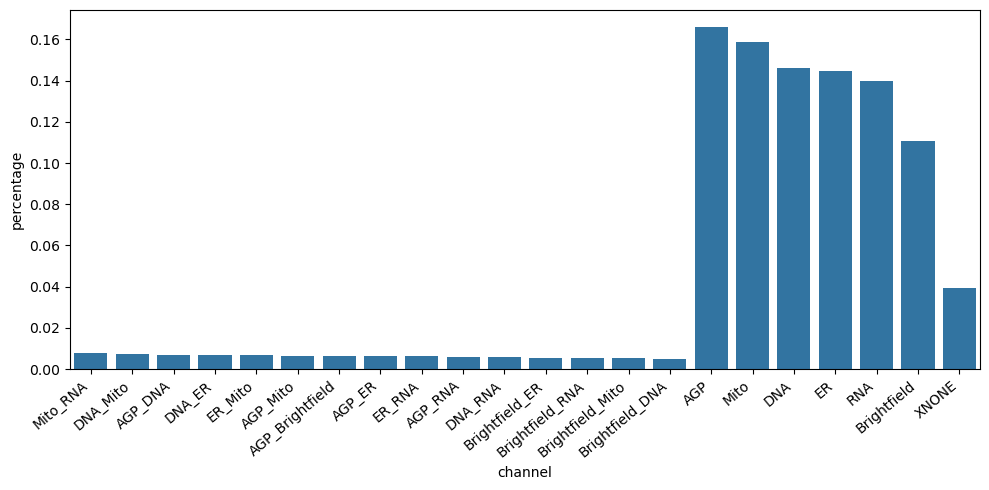


Analyzing category: progen
Logistic Regression Accuracy Score for progen: 0.7500
Number of significant features for progen: 2705


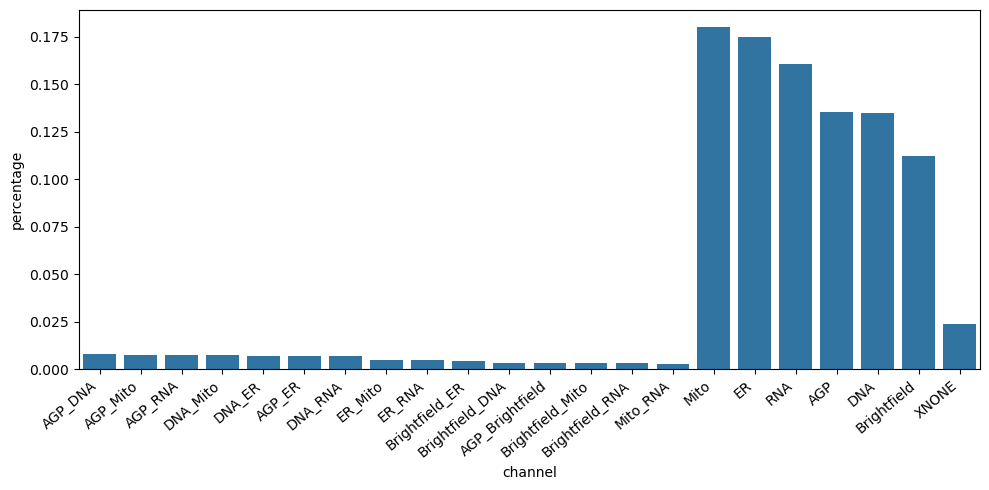


Analyzing category: neuron
Logistic Regression Accuracy Score for neuron: 0.5486
Number of significant features for neuron: 318


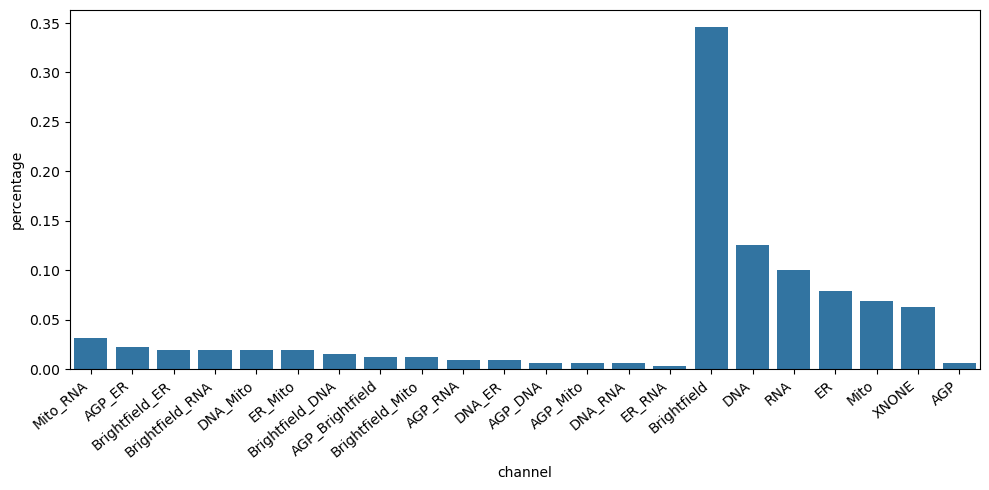


Analyzing category: astro
Logistic Regression Accuracy Score for astro: 0.8611
Number of significant features for astro: 3504


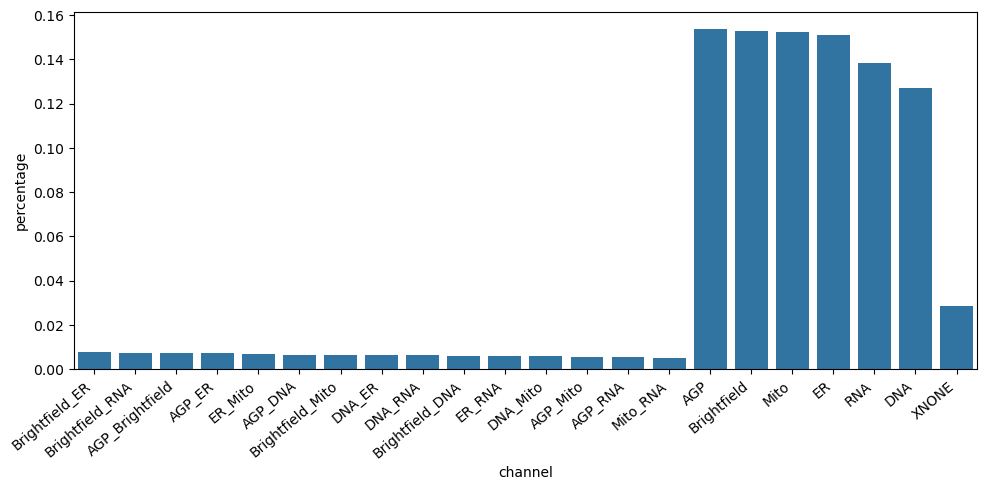

In [16]:
def analyze_by_category(
    df, category_col, target_col, target_col_mapping_dict, feature_cols
):
    """
    Analyze the data by category using logistic regression and Mann-Whitney U-test.

    Parameters:
    - df: DataFrame, the data.
    - category_col: str, the name of the column to define categories.
    - target_col: str, the name of the column to define groups for logistic regression and U-test.
    - target_col_mapping_dict: dict, a dictionary mapping target_col values to integers.
    - feature_cols: list, the list of feature columns to use for analysis.
    """
    categories = df[category_col].unique()

    target_col_encoded = f"{target_col}_encoded"

    df[target_col_encoded] = df[target_col].map(target_col_mapping_dict).fillna(-1)

    for category in categories:
        print(f"\nAnalyzing category: {category}")
        category_df = df[df[category_col] == category]

        # Prepare data for logistic regression
        X_train, X_test, y_train, y_test = split_data(
            category_df,
            feature_cols=feature_cols,
            target_col=target_col_encoded,
            group_split_col="Metadata_line_ID",
        )

        # Perform logistic regression
        score, feature_weights = logistic_regression(X_train, y_train, X_test, y_test)
        print(f"Logistic Regression Accuracy Score for {category}: {score:.4f}")

        # Perform Mann-Whitney U-test
        results = mann_whitney_u_test(
            category_df, feature_cols=feature_cols, target_col=target_col_encoded
        )

        # Visualize significant features
        significant_features = results.query("q_value < 0.05")["feature"].tolist()

        print(
            f"Number of significant features for {category}: {len(significant_features)}"
        )

        if significant_features:
            # print(f"Significant features for {category}: {significant_features}")
            # Print just the number of significant features
            visualize_channels(significant_features)

        print(70 * "=")


feature_cols = df.columns[df.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()

# HACK to reduce the number of features
# feature_cols = feature_cols[:30]

# Call the function with the appropriate parameters
analyze_by_category(
    df=df,
    category_col="Metadata_cell_type",
    target_col="Metadata_line_condition",
    target_col_mapping_dict={"control": 0, "deletion": 1},
    feature_cols=feature_cols,
)